In [203]:
import logging
import os
import datetime
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [204]:
CO_Gray = '#404544'
CO_Orange = '#f26a3f'
CO_Blue = '#6dc4bc'
CO_Yellow = '#f9c20a'
CO_Cyan = '#005a65'
color_list = [CO_Gray, CO_Orange, CO_Blue, CO_Yellow, CO_Cyan]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [205]:
def init_logging():
    BASE_DIR = os.path.dirname(os.path.realpath("__file__"))
    LOG_DIR = f'{BASE_DIR}/logs/'
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
    today = datetime.datetime.now().strftime('%Y%m%d')
    i = 0
    while os.path.exists(f'{LOG_DIR}post_{today}_%s.log' % i):
        i += 1
    LOG_FILE = f'{LOG_DIR}post_{today}_%s.log' % i
    logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG,format='%(asctime)s : %(process)d : %(levelname)s : %(message)s')
    logging.info('Logging started')
    logging.info(f'Log file saved to {LOG_FILE}') 

In [206]:
def open_data_file():
    root = tk.Tk()
    root.withdraw()
    logging.info('Prompting user to select data file')
    #return filedialog.askopenfilename()
    return 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_103149_trial_data_Max_Mass_Flow.csv'

In [207]:
def load_data_file(f):
    df = pd.read_table(f,header=0,delimiter=',',index_col=0)
    logging.info('Converted data file to data frame')
    num_rows = len(df)
    logging.info(f'Dataframe has {num_rows} rows')
    #df = pd.Series.str.split(',', expand=True)
    return df

In [208]:
def valve_percent(df):
    df['Valve Percent'] = df['Valve Position']/90*100
    return df

In [209]:
init_logging()
f = open_data_file()
f = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_103149_trial_data_Max_Mass_Flow.csv'
logging.info(f'Opened {f}')

df = load_data_file(f)
df = valve_percent(df)
df.head()

,Time,Elapsed Time,Mass Flow,MFM Temperature,Inlet Temperature,Midpoint Temperature,Outlet Temperature,Heater Temperature,Supply Pressure,Inlet Pressure,Midpoint Pressure,Outlet Pressure,Valve Position,Heater Power,Heater Current,Valve Percent
0,1.647441e+09,0.046115,0.01,23.90,21.50,21.50,23.25,23.25,-0.927734,0.0,0.0,0.0,90.0,0.0,-0.08,100.0
1,1.647441e+09,0.265554,0.01,23.94,21.75,21.50,22.50,22.25,-1.171875,0.0,0.0,0.0,90.0,0.0,-0.03,100.0
2,1.647441e+09,0.375094,0.00,23.99,21.50,22.00,22.25,22.25,-1.171875,0.0,0.0,0.0,90.0,0.0,-0.03,100.0
3,1.647441e+09,0.593635,0.02,23.96,21.50,21.50,23.25,22.75,-1.171875,0.0,0.0,0.0,90.0,0.0,0.03,100.0
4,1.647441e+09,0.701452,0.01,23.92,21.50,22.25,22.50,22.50,-1.171875,0.0,0.0,0.0,90.0,0.0,-0.11,100.0


In [210]:
sns.set_style('white') # darkgrid, white grid, dark, white and ticksplt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

colors = sns.color_palette('deep')

(0.0, 90.0)

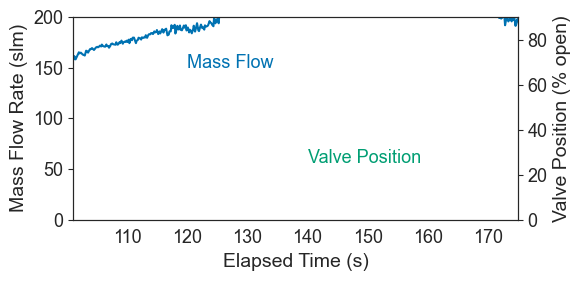

In [211]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,3),tight_layout=True)
#fig.suptitle('Mass Flow Controller Characertization\nTarget: 100 slm')

sns.lineplot(ax=ax,x="Elapsed Time",y="Mass Flow",data = df,color='C0')
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Mass Flow Rate (slm)')
plt.annotate('Mass Flow',(120,150),color='C0')
ax.set_xlim(101,175)
ax.set_ylim(0,200)

ax2 = ax.twinx()
sns.lineplot(ax=ax2,x="Elapsed Time",y="Valve Percent",data=df,color='C1')
ax2.set_ylabel('Valve Position (% open)')
plt.annotate('Valve Position',(140,25),color='C1')
ax2.set_ylim(0,90)

#plt.savefig("Figures/valve_repeatability_zoom.svg",format="svg")

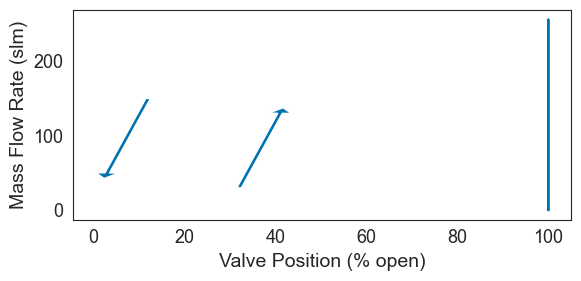

In [212]:
fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)
plt.plot(df["Valve Percent"],df["Mass Flow"])
plt.xlabel('Valve Position (% open)')
plt.ylabel('Mass Flow Rate (slm)')
plt.arrow(32,30,9,100,width=1,head_width=5)
plt.arrow(12,150,-9,-100,width=1,head_width=5)
#plt.savefig('Figures/valve_hysteresis.svg',format='svg')

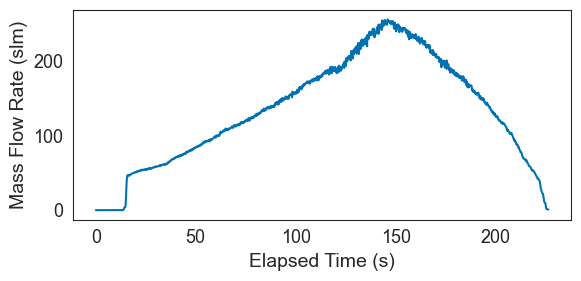

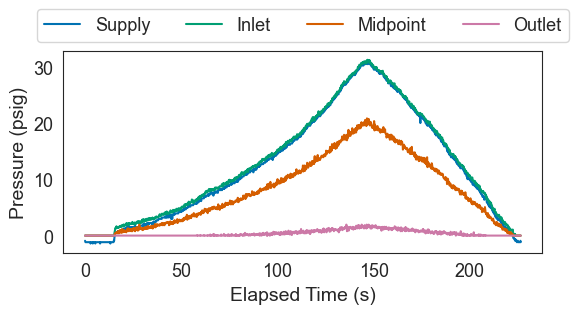

In [213]:
fig,ax = plt.subplots(nrows=1,figsize=(6,3),tight_layout=True)
fig.tight_layout(pad=0.3)

sns.lineplot(x=df["Elapsed Time"],y=df["Mass Flow"],ax=ax)
#ax.annotate("Mass Flow",(50,150),color="C0")
ax.set_ylabel("Mass Flow Rate (slm)")
ax.set_xlabel("Elapsed Time (s)")
#ax.set_ylim(0,200)
#ax2 = ax.twinx()
#sns.lineplot(x=df["Elapsed Time"],y=df["Valve Percent"],ax=ax2,color="C1")
#ax2.annotate("Valve Position",(100,40),color="C1")
#ax2.set_ylabel("Valve Position (% open)")
#ax2.set_ylim(0,100)
fig.savefig('Figures/max_mass_flow.svg',format='svg')

fig,ax = plt.subplots(figsize=(6,3.3),tight_layout=True)
sns.lineplot(x=df["Elapsed Time"],y=df["Supply Pressure"],ax=ax)
sns.lineplot(x=df["Elapsed Time"],y=df["Inlet Pressure"],ax=ax)
sns.lineplot(x=df["Elapsed Time"],y=df["Midpoint Pressure"],ax=ax)
sns.lineplot(x=df["Elapsed Time"],y=df["Outlet Pressure"],ax=ax)
ax.legend(labels=["Supply","Inlet","Midpoint","Outlet"],loc='upper center',ncol=4,bbox_to_anchor=(0.5,1.25))
ax.set_xlabel("Elapsed Time (s)")
ax.set_ylabel("Pressure (psig)")

fig.savefig('Figures/max_mass_flow_pressure.svg',format='svg')

<AxesSubplot:xlabel='Mass Flow', ylabel='Count'>

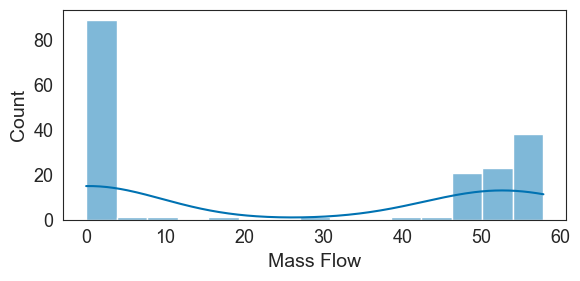

In [214]:
data = df.iloc[0:177]

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)
sns.histplot(x=data["Mass Flow"],kde=True,bins=15)

In [215]:
mdot = df["Mass Flow"]
settled_mdot = mdot.tail(100).mean()
print(175-settled_mdot)
max_mdot_loc = mdot.idxmax()
max_mdot = mdot.max()
print(max_mdot)
overshoot = (max_mdot/settled_mdot-1)*100
print(overshoot)
start_loc = df["Valve Position"].gt(0).values.argmax()
print(start_loc)
start_time = df["Elapsed Time"].iloc[start_loc]
settled_loc = df["Mass Flow"].gt(0.9*(settled_mdot)).idxmax()
print(settled_loc)
settled_time = df.iloc[settled_loc]["Elapsed Time"]
print(settled_time-start_time)
rising_time = settled_time - df["Elapsed Time"].iloc[df["Mass Flow"].gt(0.1*settled_mdot).idxmax()]
print(rising_time)

124.1406
255.83
403.01419206675666
0
94
15.668802499771116
0.8691985607147199


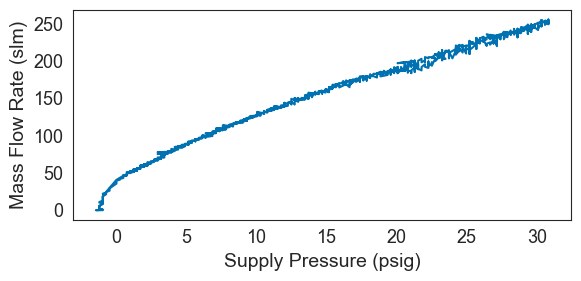

In [216]:
fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

plt.plot(df["Supply Pressure"],df["Mass Flow"])
#sns.lineplot(x="Supply Pressure",y="Mass Flow",data=df,ax=ax)
tick_spacing = 50
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_xlabel('Supply Pressure (psig)')
ax.set_ylabel("Mass Flow Rate (slm)")
fig.savefig('Figures/max_mass_flow_pressure_sweep.svg',format='svg')

In [217]:
max_mdot = {}
f10 = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_110801_trial_data_10psig.csv'
df10 = load_data_file(f10)
df10 = valve_percent(df10)
max_mdot["10"] = df10["Mass Flow"].tail(50).mean()

f15 = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_101654_trial_data_15psig.csv'
df15 = load_data_file(f15)
df15 = valve_percent(df15)
max_mdot["15"] = df15["Mass Flow"].tail(50).mean()

f20 = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_101954_trial_data_20psig.csv'
df20 = load_data_file(f20)
df20 = valve_percent(df20)
max_mdot["20"] = df20["Mass Flow"].tail(50).mean()

f25 = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_102341_trial_data_25psig.csv'
df25 = load_data_file(f25)
df25 = valve_percent(df25)
max_mdot["25"] = df25["Mass Flow"].tail(50).mean()

f30 = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_102701_trial_data_30psig.csv'
df30 = load_data_file(f30)
df30 = valve_percent(df30)
max_mdot["30"] = df30["Mass Flow"].tail(50).mean()

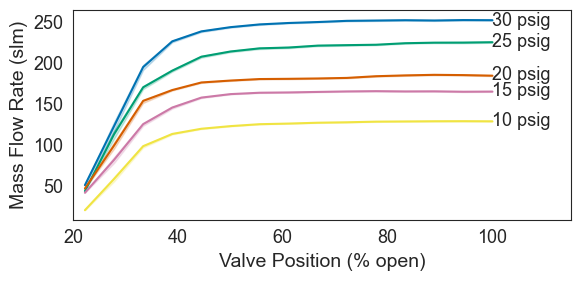

In [218]:
fig,ax1 = plt.subplots(figsize=(6,3),tight_layout=True)
#ax2 = ax1.twinx()

#sns.lineplot(x="Elapsed Time",y="Valve Percent",data=df10,ax=ax2,color='C1')

sns.lineplot(x="Valve Percent",y="Mass Flow",data=df30,ax=ax1)
sns.lineplot(x="Valve Percent",y="Mass Flow",data=df25,ax=ax1)
sns.lineplot(x="Valve Percent",y="Mass Flow",data=df20,ax=ax1)
sns.lineplot(x="Valve Percent",y="Mass Flow",data=df15,ax=ax1)
sns.lineplot(x="Valve Percent",y="Mass Flow",data=df10,ax=ax1)
#plt.plot(df20["Elapsed Time"],df20["Mass Flow"])

ax1.set_xlim((20,115))
ax1.set_xlabel("Valve Position (% open)")
ax1.set_ylabel("Mass Flow Rate (slm)")
ax1.annotate('10 psig',(100,123))
ax1.annotate('15 psig',(100,160))
ax1.annotate('20 psig',(100,180))
ax1.annotate('25 psig',(100,220))
ax1.annotate('30 psig',(100,245))

ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax2.set_ylabel("Valve Position (% open)")
#ax1.legend(labels=["30","25","20","15","10"],title="Supply Pressure (psig)",loc="center right",bbox_to_anchor=(1.6,0.5))
#fig.savefig('Figures/mass_flow_vs_pressure.svg',format='svg')

(5.0, 35.0)

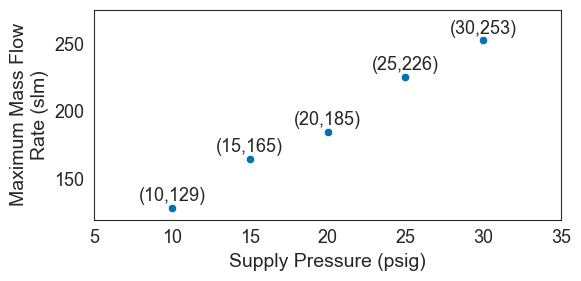

In [219]:
fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)
x = [float(key) for key in [*max_mdot]]
y = [*max_mdot.values()]
sns.scatterplot(x=x,y=y,ax=ax)
ax.set_xlabel('Supply Pressure (psig)')
ax.set_ylabel('Maximum Mass Flow\nRate (slm)')
for c,v in enumerate(y):
    plt.text(x[c],y[c]+5,f'({x[c]:.0f},{v:.0f})',horizontalalignment='center')
ax.set_ylim((120,275))
ax.set_xlim((5,35))

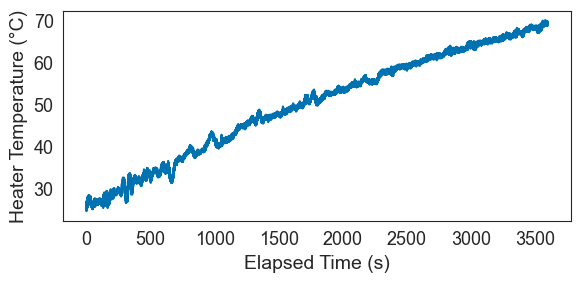

In [220]:
f = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_123522_trial_data_Heat_to_100.csv'
df = load_data_file(f)
df = valve_percent(df)

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

sns.lineplot(x='Elapsed Time',y='Heater Temperature',data=df)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel(f'Heater Temperature (\N{DEGREE SIGN}C)')
ax.set_xlabel('Elapsed Time (s)')

plt.savefig('Figures/heat_to_100.svg',format='svg')

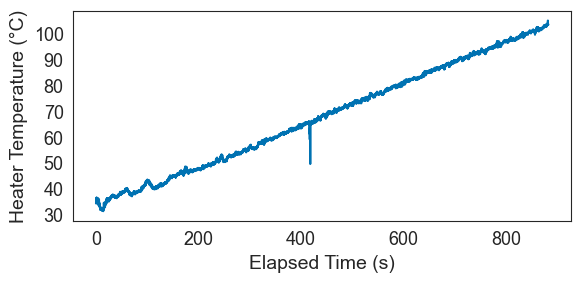

In [221]:
f = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_155901_trial_data_Heat_to_500.csv'
df = load_data_file(f)
df = valve_percent(df)

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

sns.lineplot(x='Elapsed Time',y='Heater Temperature',data=df)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel(f'Heater Temperature (\N{DEGREE SIGN}C)')
ax.set_xlabel('Elapsed Time (s)')

plt.savefig('Figures/heat_to_500.svg',format='svg')

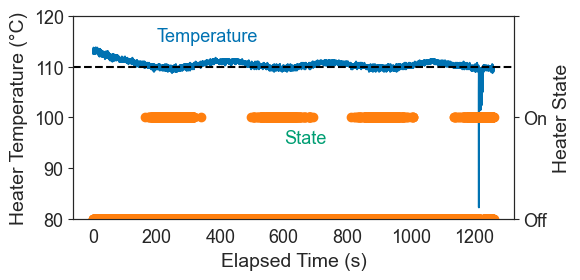

In [222]:
f = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_163717_trial_data_110C_test.csv'
df = load_data_file(f)
df = valve_percent(df)

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

sns.lineplot(x='Elapsed Time',y='Heater Temperature',data=df)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel(f'Heater Temperature (\N{DEGREE SIGN}C)')
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylim((80,120))
plt.axhline(y=110,color='k',linestyle='--')
ax.annotate('Temperature',(200,115),color='C0')

ax2 = ax.twinx()
plt.scatter(df['Elapsed Time'],df['Heater State'],c='#ff7f0e')
ax2.set_ylim((0,2))
ax2.set_ylabel('Heater State')
ax2.set_yticks([0,1,2])
ax2.set_yticklabels(['Off','On',''])
ax2.annotate('State',(600,0.75),color='C1')
plt.savefig('Figures/heater_controller.svg',format='svg')

35.560700000000004
191.0426
37.9075
15.7025
65.0302203195
28.881652312070006


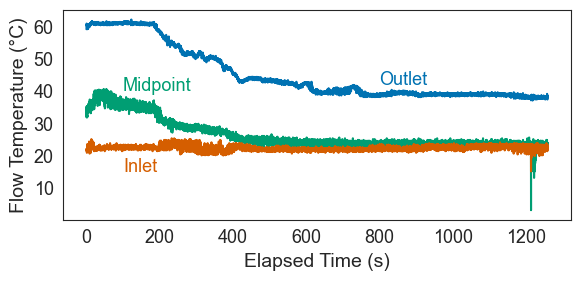

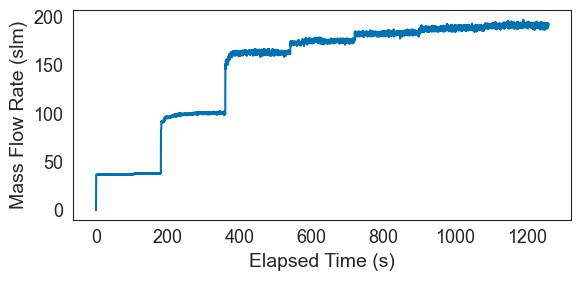

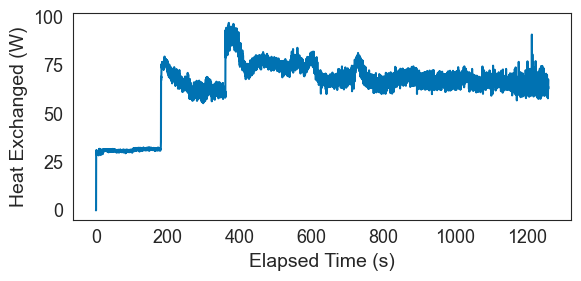

In [226]:
f = 'C:/Users/noahr/Documents/OSU/Thesis/Data to process/2022_3_16_163717_trial_data_110C_test.csv'
df = load_data_file(f)
df = valve_percent(df)

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

sns.lineplot(x='Elapsed Time',y='Outlet Temperature',data=df)
sns.lineplot(x='Elapsed Time',y='Midpoint Temperature',data=df)
sns.lineplot(x='Elapsed Time',y='Inlet Temperature',data=df)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel(f'Flow Temperature (\N{DEGREE SIGN}C)')
ax.set_xlabel('Elapsed Time (s)')
ax.annotate('Outlet',(800,42),color='C0')
ax.annotate('Midpoint',(100,40),color='C1')
ax.annotate('Inlet',(100,15),color='C2')
plt.savefig('Figures/110_temperature_profile.svg',format='svg')

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

sns.lineplot(x='Elapsed Time',y='Mass Flow',data=df)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_ylabel(f'Mass Flow Rate (slm)')
ax.set_xlabel('Elapsed Time (s)')
plt.savefig('Figures/110_mass_flow_profile.svg',format='svg')

print(df["Mass Flow"].head(100).mean())
print(df["Mass Flow"].tail(100).mean())

print(df["Outlet Temperature"].head(100).mean()-df["Inlet Temperature"].head(100).mean())
print(df["Outlet Temperature"].tail(100).mean()-df["Inlet Temperature"].tail(100).mean())

fig,ax = plt.subplots(figsize=(6,3),tight_layout=True)

sns.lineplot(x='Elapsed Time',y='Fluid Heat',data=df)
ax.yaxis.set_major_locator(ticker.MultipleLocator(25))
ax.set_ylabel('Heat Exchanged (W)')
ax.set_xlabel('Elapsed Time (s)')
plt.savefig('Figures/110_heat_exchanged.svg',format='svg')
print(df["Fluid Heat"].tail(100).mean())
print(df["Fluid Heat"].head(100).mean())
